In [1]:
# importing modules

# Accessing NHL api
import requests

# Holding and working with data
import pandas as pd
import numpy as np

# Graphing Data
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

C:\Users\James\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
# Getting data
skaters_url = 'http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=skatersummary&sort=[{%22property%22:%22points%22,%22direction%22:%22DESC%22},{%22property%22:%22goals%22,%22direction%22:%22DESC%22},{%22property%22:%22assists%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20172018%20and%20seasonId%3C=20172018'

response = requests.get(skaters_url)
response.raise_for_status()
playerData = pd.DataFrame(response.json()['data'])

In [24]:
# Checking out data features
list(playerData)

['assists',
 'faceoffWinPctg',
 'gameWinningGoals',
 'gamesPlayed',
 'goals',
 'otGoals',
 'penaltyMinutes',
 'playerBirthCity',
 'playerBirthCountry',
 'playerBirthDate',
 'playerBirthStateProvince',
 'playerDraftOverallPickNo',
 'playerDraftRoundNo',
 'playerDraftYear',
 'playerFirstName',
 'playerHeight',
 'playerId',
 'playerInHockeyHof',
 'playerIsActive',
 'playerLastName',
 'playerName',
 'playerNationality',
 'playerPositionCode',
 'playerShootsCatches',
 'playerTeamsPlayedFor',
 'playerWeight',
 'plusMinus',
 'points',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'seasonId',
 'shGoals',
 'shPoints',
 'shiftsPerGame',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame']

In [25]:
# Dropping goalies
playerData = playerData[playerData.playerPositionCode != 'G']

In [26]:
# Dopping data that should not affect position
playerData = playerData.drop(columns=['playerBirthCity', 'playerBirthCountry', 'playerBirthStateProvince', 'playerInHockeyHof', 
                                      'playerFirstName', 'playerLastName', 'playerNationality', 'playerDraftYear',
                                      'playerDraftRoundNo', 'playerTeamsPlayedFor', 'seasonId', 'playerShootsCatches',
                                      'playerName', 'gameWinningGoals', 'points', 'penaltyMinutes', 'shiftsPerGame',
                                      'shPoints', 'shGoals', 'playerWeight', 'playerHeight', 'playerId', 'otGoals',
                                      'plusMinus', 'ppGoals', 'gamesPlayed'])
list(playerData)


['assists',
 'faceoffWinPctg',
 'goals',
 'playerBirthDate',
 'playerDraftOverallPickNo',
 'playerIsActive',
 'playerPositionCode',
 'pointsPerGame',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame']

In [27]:
# Removing inactive players
playerData = playerData.query('playerIsActive != 0')
playerData = playerData.drop(columns=['playerIsActive'])

   assists  faceoffWinPctg  goals playerBirthDate  playerDraftOverallPickNo  \
0       67          0.4136     41      1997-01-13                       1.0   
1       68          0.5863     34      1988-01-12                      22.0   
2       61          0.6000     39      1993-06-17                      58.0   
3       56          0.4372     42      1986-07-31                       2.0   
4       58          0.4191     39      1995-09-01                       1.0   

   playerIsActive playerPositionCode  pointsPerGame  ppPoints  shootingPctg  \
0               1                  C         1.3170        20        0.1496   
1               1                  C         1.2439        36        0.1761   
2               1                  R         1.2500        36        0.1397   
3               1                  C         1.2564        38        0.1757   
4               1                  C         1.3108        32        0.1373   

   shots  timeOnIcePerGame  
0    274         1293

In [28]:
# Checking for any missing values
playerData.isna().sum()

assists                       0
faceoffWinPctg                0
goals                         0
playerBirthDate               0
playerDraftOverallPickNo    116
playerPositionCode            0
pointsPerGame                 0
ppPoints                      0
shootingPctg                  0
shots                         0
timeOnIcePerGame              0
dtype: int64

In [8]:
# We can see that 116 players went undrafted so we will check to see
# the max draft number
maxDraftNum = playerData['playerDraftOverallPickNo'].max()
playerData['playerDraftOverallPickNo'] = playerData['playerDraftOverallPickNo'].fillna(maxDraftNum + 1)

In [9]:
# Checking to see if the missing values were filled in
playerData.isna().sum()

assists                     0
faceoffWinPctg              0
goals                       0
playerBirthDate             0
playerDraftOverallPickNo    0
playerPositionCode          0
pointsPerGame               0
ppPoints                    0
shootingPctg                0
shots                       0
timeOnIcePerGame            0
dtype: int64

In [10]:
# Checking format and data type of playerBirtDate
print(playerData.playerBirthDate.dtype)
print(playerData[:1].playerBirthDate)

object
0    1997-01-13
Name: playerBirthDate, dtype: object


In [11]:
# Adding age column and roughly calculating age based off birth year *note player data is from 2017-2018 season
playerData['playerBirthDate'] = playerData['playerBirthDate'].apply(lambda x: x[:4])
playerData['age'] = 2017 - playerData['playerBirthDate'].astype(int)
playerData = playerData.drop(columns=['playerBirthDate'])
playerData.head()

,assists,faceoffWinPctg,goals,playerDraftOverallPickNo,playerPositionCode,pointsPerGame,ppPoints,shootingPctg,shots,timeOnIcePerGame,age
0,67,0.4136,41,1.0,C,1.3170,20,0.1496,274,1293.0975,20
1,68,0.5863,34,22.0,C,1.2439,36,0.1761,193,1221.8048,29
2,61,0.6000,39,58.0,R,1.2500,36,0.1397,279,1189.2875,24
3,56,0.4372,42,2.0,C,1.2564,38,0.1757,239,1139.3974,31
4,58,0.4191,39,1.0,C,1.3108,32,0.1373,284,1194.3108,22


In [12]:
# Mapping 'R' (Right Wing) and 'L' (Left Wing) to just 'W' (Wing)
wings = {'R': 'W', 'L': 'W', 'C': 'C', 'D': 'D'}
playerData['playerPositionCode'] = playerData['playerPositionCode'].map(wings)
playerData.head()

,assists,faceoffWinPctg,goals,playerDraftOverallPickNo,playerPositionCode,pointsPerGame,ppPoints,shootingPctg,shots,timeOnIcePerGame,age
0,67,0.4136,41,1.0,C,1.3170,20,0.1496,274,1293.0975,20
1,68,0.5863,34,22.0,C,1.2439,36,0.1761,193,1221.8048,29
2,61,0.6000,39,58.0,W,1.2500,36,0.1397,279,1189.2875,24
3,56,0.4372,42,2.0,C,1.2564,38,0.1757,239,1139.3974,31
4,58,0.4191,39,1.0,C,1.3108,32,0.1373,284,1194.3108,22


In [13]:
# Splitting data up into my features and my label
playerData.reset_index(drop=True) 
X = playerData.drop(columns=['playerPositionCode']).copy()
feature_list = list(X)
y = playerData['playerPositionCode']
X = preprocessing.scale(X)

In [14]:
# Splitting our dataframe into our taining and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

0.7469135802469136


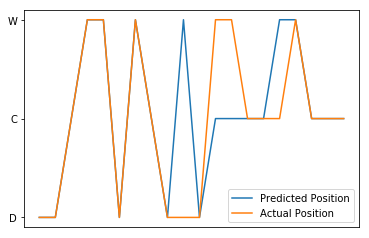

In [15]:
rf = RandomForestClassifier(n_estimators=100,max_features=None)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print(rf.score(X_test, y_test))

plt.plot(pred[:20])
plt.plot(y_test.values[:20])
plt.xticks([])
plt.legend(['Predicted Position', 'Actual Position'])

In [16]:
# Checking out most important features
importances = pd.DataFrame({'feature':feature_list,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
faceoffWinPctg,0.462
timeOnIcePerGame,0.172
shootingPctg,0.071
shots,0.063
age,0.063
playerDraftOverallPickNo,0.052
pointsPerGame,0.042
assists,0.034
goals,0.023


0.7098765432098766


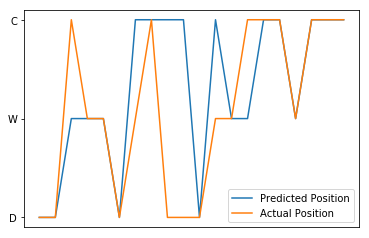

In [17]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(knn.score(X_test, y_test))

plt.plot(pred[:20])
plt.plot(y_test.values[:20])
plt.xticks([])
plt.legend(['Predicted Position', 'Actual Position'])

In [18]:
# Mapping 'W' (Wing) and 'C' (Center) to 'F' (Forward) to  check how accurately it can predict forwards from defence
wings = {'W': 'F', 'C': 'F', 'D': 'D'}
playerData['playerPositionCode'] = playerData['playerPositionCode'].map(wings)
playerData.head()

,assists,faceoffWinPctg,goals,playerDraftOverallPickNo,playerPositionCode,pointsPerGame,ppPoints,shootingPctg,shots,timeOnIcePerGame,age
0,67,0.4136,41,1.0,F,1.3170,20,0.1496,274,1293.0975,20
1,68,0.5863,34,22.0,F,1.2439,36,0.1761,193,1221.8048,29
2,61,0.6000,39,58.0,F,1.2500,36,0.1397,279,1189.2875,24
3,56,0.4372,42,2.0,F,1.2564,38,0.1757,239,1139.3974,31
4,58,0.4191,39,1.0,F,1.3108,32,0.1373,284,1194.3108,22


In [19]:
# Splitting data up into my features and my label

X = playerData.drop(columns=['playerPositionCode']).copy()
y = playerData['playerPositionCode']
X = preprocessing.scale(X)

In [20]:
# Splitting our dataframe into our taining and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

0.9320987654320988


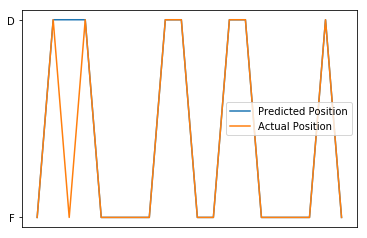

In [21]:
rf = RandomForestClassifier(n_estimators=100,max_features=None)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print(rf.score(X_test, y_test))

plt.plot(pred[:20])
plt.plot(y_test.values[:20])
plt.xticks([])
plt.legend(['Predicted Position', 'Actual Position'])